In [2]:
from pathlib import Path

import numpy as np
import torch

import pandas as pd
import matplotlib.pyplot as plt

import gym
from lagom.envs.wrappers import TimeLimit
from lagom.envs.wrappers import ClipAction
from lagom.envs import make_vec_env
from lagom.utils import pickle_load
from lagom.utils import yaml_load
from lagom.vis import lineplot
from lagom.vis import auto_ax


def get_configs(log_folder):
    data = pickle_load(Path(log_folder) / 'configs.pkl')
    configs = pd.DataFrame(data, columns=data[0].keys())
    return configs


def load_loggings(log_folder, ID, f):
    p = Path(log_folder)/str(ID)
    out = []
    for seed_folder in p.iterdir():
        if seed_folder.is_dir() and (seed_folder/f).exists():
            out.append(pickle_load(seed_folder/f))
    return out


def get_items(loggings, key):
    out = []
    for logging in loggings:
        items = [x[key][0] for x in logging]
        out.append(items)
    return out


def get_xy(loggings, x_key, y_key):
    x = get_items(loggings, x_key)
    y = get_items(loggings, y_key)
    return x, y


def plot_curve(ax, log_folder, file_name, env_id, x_key, y_key, xlabel, ylabel, legend):
    err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
    configs = get_configs(log_folder)
    for ID in configs[configs['env.id'] == env_id]['ID']:
        loggings = load_loggings(log_folder, ID, file_name)
        x, y = get_xy(loggings, x_key, y_key)
        ax = lineplot(ax, x, y, **err_kws, label=legend)
    ax = auto_ax(ax, title=env_id, xlabel=xlabel, ylabel=ylabel, num_tick=6, xmagnitude=None, legend_kws=None)
    #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})
    return ax


def make_video(log_folder, agent_class, seed, num_iter):
    log_folder = Path(log_folder)
    config = yaml_load(log_folder / 'config.yml')
    def make_env():
        env = gym.make(config['env.id'])
        env = env.env  # strip out gym TimeLimit, TODO: remove until gym update it
        env = TimeLimit(env, env.spec.max_episode_steps)
        env = ClipAction(env)
        anim_path = log_folder / str(seed) / 'anim'
        if not anim_path.exists():
            anim_path.mkdir(parents=True)
        env = gym.wrappers.Monitor(env, anim_path, force=True)
        return env
    env = make_vec_env(make_env, 1, seed, 'serial')  # single environment
    def standardize(observation, mean, var):
        return (observation - mean)/np.sqrt(var + 1e-8)
    path_obs_moments = log_folder / str(seed) / f'obs_moments_{num_iter}.pth'
    if path_obs_moments.exists():
        obs_mean, obs_var = np.load(path_obs_moments)
    agent = agent_class(config, env, 'cpu')
    agent.load(log_folder / str(seed) / f'agent_{num_iter}.pth')
    agent.eval()
    
    rewards = 0.0
    observation = env.reset()
    with torch.no_grad():
        for t in range(env.spec.max_episode_steps):
            if path_obs_moments.exists():
                observation = standardize(observation, obs_mean, obs_var)
            action = agent.choose_action(observation)['raw_action']
            observation, reward, done, info = env.step(action)
            rewards += reward[0]
            if done[0]:
                break
    env.close()
    return f'Evaluation return: {rewards}'

## VPG

In [14]:
log_folder = 'vpg/logs/default_'
configs = get_configs(log_folder)
configs

,ID,cuda,log.dir,log.freq,checkpoint.freq,env.standardize_obs,env.standardize_reward,env.time_aware_obs,nn.sizes,agent.lr,...,agent.entropy_coef,agent.value_coef,env.clip_action,agent.std0,agent.std_style,agent.std_range,agent.beta,train.timestep,train.timestep_per_iter,env.id
0,0,True,logs/default_,10,50,True,True,False,"[64, 64]",0.001,...,0.01,0.5,True,0.5,exp,None,None,1000000,2000,HalfCheetah-v2
1,1,True,logs/default_,10,50,True,True,False,"[64, 64]",0.001,...,0.01,0.5,True,0.5,exp,None,None,1000000,2000,Hopper-v2
2,2,True,logs/default_,10,50,True,True,False,"[64, 64]",0.001,...,0.01,0.5,True,0.5,exp,None,None,1000000,2000,Walker2d-v2
3,3,True,logs/default_,10,50,True,True,False,"[64, 64]",0.001,...,0.01,0.5,True,0.5,exp,None,None,1000000,2000,Ant-v2


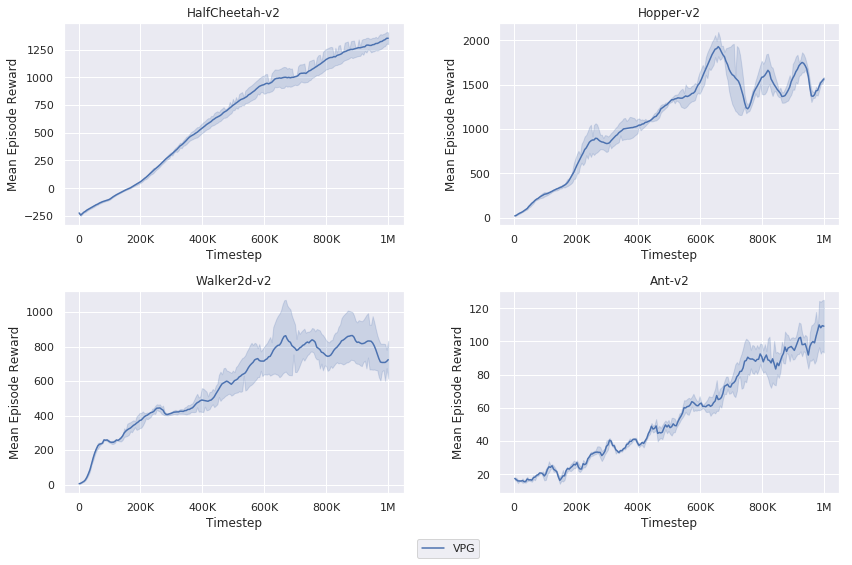

In [49]:
x_key = 'accumulated_trained_timesteps'
xlabel = 'Timestep'
y_key = 'running_mean_return'
ylabel = 'Mean Episode Reward'

envs = ['HalfCheetah-v2', 'Hopper-v2', 'Walker2d-v2', 'Ant-v2']
fig, axes = plt.subplots(2, 2, figsize=[2*6, 2*4])
for env, ax in zip(envs, axes.flatten()):
    plot_curve(ax=ax, 
               log_folder=log_folder, 
               file_name='train_logs.pkl', 
               env_id=env, 
               x_key=x_key, 
               y_key=y_key, 
               xlabel=xlabel, 
               ylabel=ylabel, 
               legend='VPG')
fig.tight_layout()
legend = ax.legend(loc='upper center', bbox_to_anchor=[-0.15, -0.2], ncol=2)
fig.savefig(f'{log_folder}/result.png', bbox_extra_artists=(legend,), bbox_inches='tight')

In [69]:
from vpg.agent import Agent
ID = 0
make_video(f'{log_folder}/{ID}', Agent, seed=1500925526, num_iter=1)

'Evaluation return: -352.3655817059259'

## PPO

In [70]:
log_folder = 'ppo/logs/default_'
configs = get_configs(log_folder)
configs

,ID,cuda,log.dir,log.freq,checkpoint.freq,env.standardize_obs,env.standardize_reward,env.time_aware_obs,nn.sizes,agent.lr,...,env.clip_action,agent.std0,agent.std_style,agent.std_range,agent.beta,train.timestep,train.timestep_per_iter,train.batch_size,train.num_epochs,env.id
0,0,True,logs/default_,10,50,True,True,False,"[64, 64]",0.001,...,True,0.5,exp,None,None,1000000,2000,256,80,HalfCheetah-v2
1,1,True,logs/default_,10,50,True,True,False,"[64, 64]",0.001,...,True,0.5,exp,None,None,1000000,2000,256,80,Hopper-v2
2,2,True,logs/default_,10,50,True,True,False,"[64, 64]",0.001,...,True,0.5,exp,None,None,1000000,2000,256,80,Walker2d-v2
3,3,True,logs/default_,10,50,True,True,False,"[64, 64]",0.001,...,True,0.5,exp,None,None,1000000,2000,256,80,Ant-v2


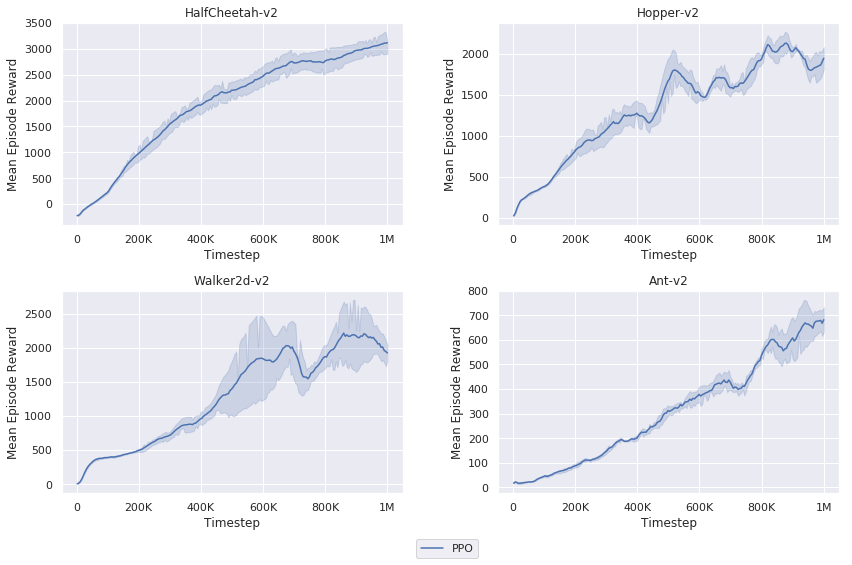

In [71]:
x_key = 'accumulated_trained_timesteps'
xlabel = 'Timestep'
y_key = 'running_mean_return'
ylabel = 'Mean Episode Reward'

envs = ['HalfCheetah-v2', 'Hopper-v2', 'Walker2d-v2', 'Ant-v2']
fig, axes = plt.subplots(2, 2, figsize=[2*6, 2*4])
for env, ax in zip(envs, axes.flatten()):
    plot_curve(ax=ax, 
               log_folder=log_folder, 
               file_name='train_logs.pkl', 
               env_id=env, 
               x_key=x_key, 
               y_key=y_key, 
               xlabel=xlabel, 
               ylabel=ylabel, 
               legend='PPO')
fig.tight_layout()
legend = ax.legend(loc='upper center', bbox_to_anchor=[-0.15, -0.2], ncol=2)
fig.savefig(f'{log_folder}/result.png', bbox_extra_artists=(legend,), bbox_inches='tight')

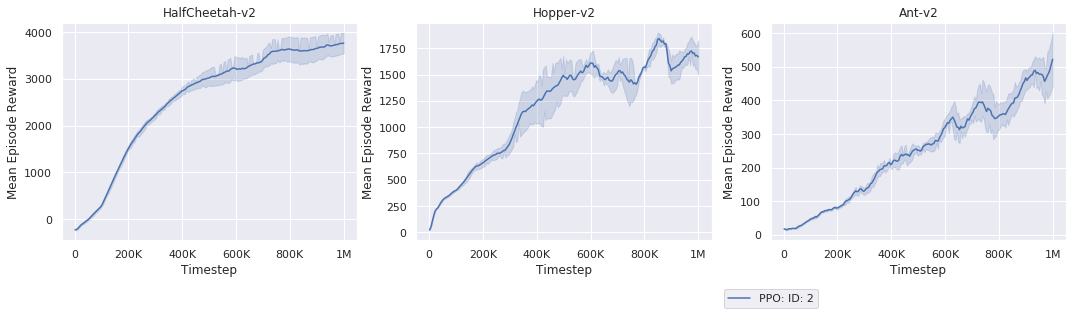

In [159]:
from lagom.vis import lineplot
from lagom.vis import auto_ax


fig, axes = plt.subplots(1, 3, figsize=[3*6, 4])
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}

x_key = 'accumulated_trained_timesteps'
xlabel = 'Timestep'
y_key = 'running_mean_return'
ylabel = 'Mean Episode Reward'

hyp = 'ID'

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'PPO: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})

ax = axes[1]
env_id = 'Hopper-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'PPO: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})   
    
    
ax = axes[2]
env_id = 'Ant-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'PPO: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})   

    
legend = ax.legend(loc='upper center', bbox_to_anchor=[0.0, -0.2], ncol=2)
fig.savefig(log_folder/'result.png', bbox_extra_artists=(ax.legend_,), bbox_inches='tight')

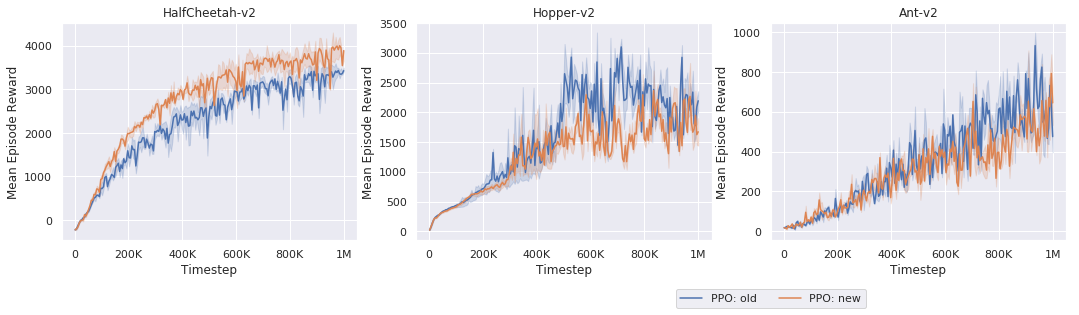

In [180]:
from lagom.vis import lineplot
from lagom.vis import auto_ax


fig, axes = plt.subplots(1, 3, figsize=[3*6, 4])
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}

x_key = 'accumulated_trained_timesteps'
xlabel = 'Timestep'
y_key = 'online_mean_return'
ylabel = 'Mean Episode Reward'

hyp = 'ID'

log_folder = Path(f'ppo/logs/default/')
d = pickle_load(log_folder/'configs.pkl')
configs = pd.DataFrame(d, columns=d[0].keys())

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'PPO: old')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})

ax = axes[1]
env_id = 'Hopper-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'PPO: old')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})   
    
    
ax = axes[2]
env_id = 'Ant-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'PPO: old')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2}) 
    
    
log_folder = Path(f'ppo/logs/default_/')
d = pickle_load(log_folder/'configs.pkl')
configs = pd.DataFrame(d, columns=d[0].keys())

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'PPO: new')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})

ax = axes[1]
env_id = 'Hopper-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'PPO: new')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})   
    
    
ax = axes[2]
env_id = 'Ant-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'PPO: new')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2}) 

    
legend = ax.legend(loc='upper center', bbox_to_anchor=[0.0, -0.2], ncol=2)
#fig.savefig(log_folder/'result.png', bbox_extra_artists=(ax.legend_,), bbox_inches='tight')

## DDPG

In [153]:
log_folder = Path(f'ddpg/logs/default_//')
d = pickle_load(log_folder/'configs.pkl')
configs = pd.DataFrame(d, columns=d[0].keys())
configs

,ID,cuda,log.dir,log.freq,env.time_aware_obs,agent.gamma,agent.polyak,agent.actor.lr,agent.actor.use_lr_scheduler,agent.critic.lr,agent.critic.use_lr_scheduler,agent.max_grad_norm,env.clip_action,replay.capacity,replay.init_size,replay.batch_size,train.timestep,eval.freq,eval.num_episode,env.id
0,0,True,logs/default_new_,1,False,0.99,0.995,0.0001,False,0.001,False,None,True,1000000,10000,100,1000000,5000,10,HalfCheetah-v2


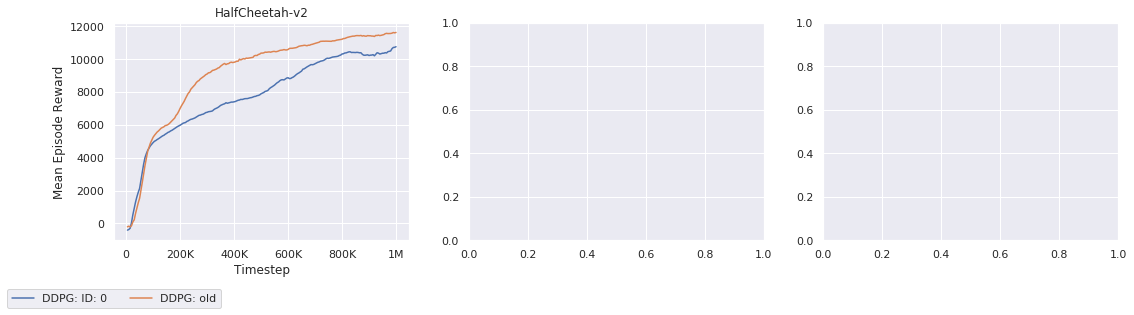

In [154]:
from lagom.vis import lineplot
from lagom.vis import auto_ax


fig, axes = plt.subplots(1, 3, figsize=[3*6, 4])
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}

x_key = 'accumulated_train_step'
xlabel = 'Timestep'
y_key = 'running_mean_return'
ylabel = 'Mean Episode Reward'

hyp = 'ID'

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'eval_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'DDPG: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})
    
    
    
    
    
log_folder = Path(f'ddpg/logs/actor_init/0.01/')
d = pickle_load(log_folder/'configs.pkl')
configs = pd.DataFrame(d, columns=d[0].keys())
x_key = 'accumulated_train_step'
ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'eval_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'DDPG: old')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})
    
    
"""
ax = axes[1]
env_id = 'Hopper-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'DDPG: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})   
    
    
ax = axes[2]
env_id = 'Ant-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'train_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'DDPG: {hyp}: {configs[hyp][ID]}')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None,
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})   
"""
    
legend = ax.legend(loc='upper center', bbox_to_anchor=[0.0, -0.2], ncol=2)
fig.savefig(log_folder/'result.png', bbox_extra_artists=(ax.legend_,), bbox_inches='tight')

In [177]:
log_folder = Path(f'ddpg/logs/actor_init/0.01')
d = pickle_load(log_folder/'configs.pkl')
configs = pd.DataFrame(d, columns=d[0].keys())
loggings = load_loggings(log_folder, 0, 'eval_logs.pkl')
x, y = get_xy(loggings, 'accumulated_train_step', 'eval_mean_return')
list(zip(x[0], y[0]))

[(5000, -205.94185),
 (10000, -134.4548),
 (15000, -289.98724),
 (20000, 79.33101),
 (25000, 1002.8968),
 (30000, 848.5508),
 (35000, 2930.148),
 (40000, 3284.398),
 (45000, 3767.1577),
 (50000, 4003.2524),
 (55000, 4546.4),
 (60000, 4858.0503),
 (65000, 4861.4985),
 (70000, 5104.236),
 (75000, 5213.88),
 (80000, 5241.905),
 (85000, 5500.4004),
 (90000, 5702.0527),
 (95000, 5514.73),
 (100000, 5817.5635),
 (105000, 5712.665),
 (110000, 5861.594),
 (115000, 5871.176),
 (120000, 5776.206),
 (125000, 6046.434),
 (130000, 6106.535),
 (135000, 5922.878),
 (140000, 6110.385),
 (145000, 6222.949),
 (150000, 6009.6704),
 (155000, 6108.784),
 (160000, 6504.639),
 (165000, 6705.5),
 (170000, 6643.497),
 (175000, 6762.086),
 (180000, 7067.784),
 (185000, 7527.747),
 (190000, 7064.3857),
 (195000, 7756.4556),
 (200000, 7749.2227),
 (205000, 7667.915),
 (210000, 7818.9814),
 (215000, 8117.129),
 (220000, 8384.087),
 (225000, 8304.587),
 (230000, 8654.078),
 (235000, 8425.149),
 (240000, 8731.653),


### TMP Plot

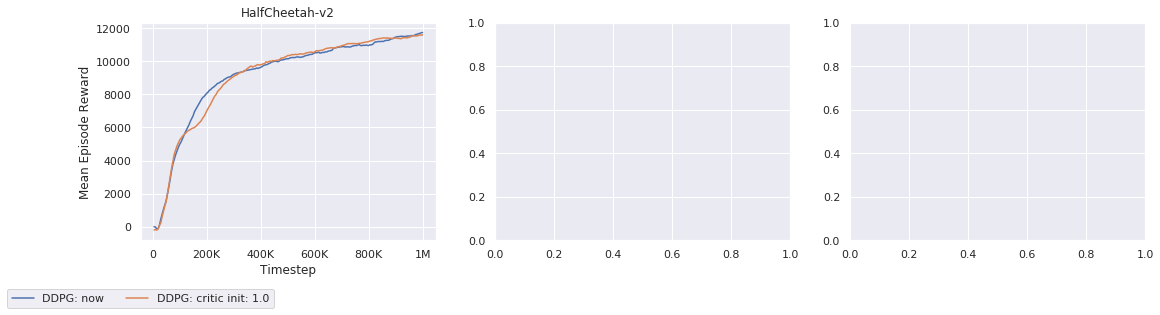

In [181]:
from lagom.vis import lineplot
from lagom.vis import auto_ax


fig, axes = plt.subplots(1, 3, figsize=[3*6, 4])
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}

x_key = 'accumulated_trained_timesteps'
xlabel = 'Timestep'
y_key = 'running_mean_return'
ylabel = 'Mean Episode Reward'


log_folder = Path(f'ddpg/logs/default_/')
d = pickle_load(log_folder/'configs.pkl')
configs = pd.DataFrame(d, columns=d[0].keys())


hyp = 'ID'

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'eval_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'DDPG: now')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})
    
    
    
log_folder = Path(f'ddpg/logs/critic_init/1.0/')
d = pickle_load(log_folder/'configs.pkl')
configs = pd.DataFrame(d, columns=d[0].keys())

x_key = 'accumulated_train_step'

hyp = 'ID'

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'eval_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'DDPG: critic init: 1.0')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})


    
legend = ax.legend(loc='upper center', bbox_to_anchor=[0.0, -0.2], ncol=2)
#fig.savefig(log_folder/'result.png', bbox_extra_artists=(ax.legend_,), bbox_inches='tight')

## TD3

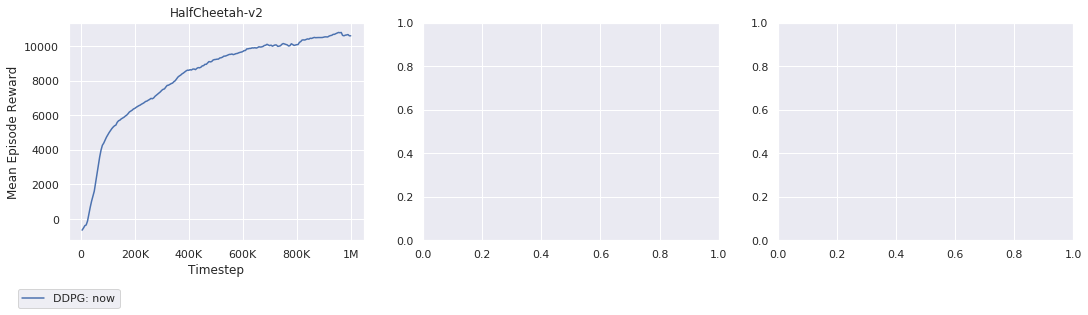

In [182]:
from lagom.vis import lineplot
from lagom.vis import auto_ax


fig, axes = plt.subplots(1, 3, figsize=[3*6, 4])
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}

x_key = 'accumulated_trained_timesteps'
xlabel = 'Timestep'
y_key = 'running_mean_return'
ylabel = 'Mean Episode Reward'


log_folder = Path(f'td3/logs/default/')
d = pickle_load(log_folder/'configs.pkl')
configs = pd.DataFrame(d, columns=d[0].keys())


hyp = 'ID'

ax = axes[0]
env_id = 'HalfCheetah-v2'
for ID in configs[configs['env.id'] == env_id]['ID']:
    loggings = load_loggings(log_folder, ID, 'eval_logs.pkl')
    x, y = get_xy(loggings, x_key, y_key)
    ax = lineplot(ax, x, y, **err_kws, label=f'DDPG: now')
ax = auto_ax(ax, 
             title=env_id, 
             xlabel=xlabel, 
             ylabel=ylabel, 
             num_tick=6, 
             xmagnitude=None, 
             legend_kws=None)
             #legend_kws={'loc': 'upper center', 'bbox_to_anchor': [0.5, -0.15], 'ncol': 2})
    
    


    
legend = ax.legend(loc='upper center', bbox_to_anchor=[0.0, -0.2], ncol=2)
#fig.savefig(log_folder/'result.png', bbox_extra_artists=(ax.legend_,), bbox_inches='tight')

## Benchmark

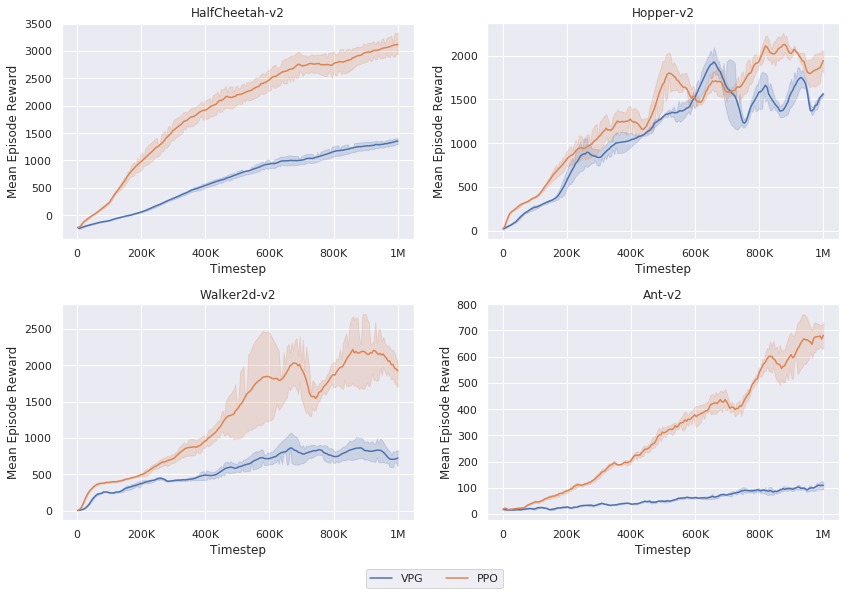

In [6]:
x_key = 'accumulated_trained_timesteps'
xlabel = 'Timestep'
y_key = 'running_mean_return'
ylabel = 'Mean Episode Reward'

envs = ['HalfCheetah-v2', 'Hopper-v2', 'Walker2d-v2', 'Ant-v2']
fig, axes = plt.subplots(2, 2, figsize=[2*6, 2*4])

log_folders = ['vpg/logs/default_', 'ppo/logs/default_']
legends = ['VPG', 'PPO']
for env, ax in zip(envs, axes.flatten()):
    for log_folder, legend in zip(log_folders, legends):
        plot_curve(ax=ax, 
                   log_folder=log_folder, 
                   file_name='train_logs.pkl', 
                   env_id=env, 
                   x_key=x_key, 
                   y_key=y_key, 
                   xlabel=xlabel, 
                   ylabel=ylabel, 
                   legend=legend)
fig.tight_layout()
legend = ax.legend(loc='upper center', bbox_to_anchor=[-0.15, -0.2], ncol=2)
fig.savefig('result.png', bbox_extra_artists=(legend,), bbox_inches='tight')